This is a page rendered by Javascript; to scrape it we need a different approach.

https://weather.gc.ca/provincialsummary_table/index_e.html?prov=mb&page=hourly

When a browser wants to access a webpage, it sends a request to the server on which the files that make up the webpage are located. The server then sends a response consisting of the page’s source code back to the browser. The browser then interprets the HTML, CSS, etc, in the source code, allows any Javascript to run, and displays the page.

Of the parts that comprise the source code of a webpage, the Javascript code is of particular interest to us in this article. When a page is loaded into a browser, it becomes a document object, whose HTML elements, or element nodes, Javascript can access. As it runs, Javascript can create new HTML elements and append them to the document. A page on which this occurs is called a page rendered by Javascript. The new elements will not be present in the original source code of the page, the code that you see when you right-click and press “view page source”; but they will be present in the code that you see if you download the page as an HTML document and open it in a text editor, or in the code in the “elements” tab in your browser’s developer tools. This HTML code, which can be retrieved by JavaScript using the DOM's innerHTMLproperty, constitutes the code of the completed webpage that the browser displays after the Javascript has finished running, and has all of the data that you need for scraping.

Python cannot access this code without the support of a browser. When a Python library such as urllib or requests sends a request to a server, it receives the source code of the webpage, just like a browser does. However, Python cannot run Javascript and allow it to create the elements that hold the content that you need to scrape; the most it can do is parse the source code. In a situation like this, one in which you have to scrape content loaded dynamically by Javascript, content that is not present in the source code of the page, the Python module Selenium comes in handy.


**Selenium** is a module that allows you to access a web browser through Python. With Selenium, you can use Python code to open a web browser, navigate to a page, log in (if needed), and return the page's inner HTML, from which you can then scrape the data you need. In the following, I will describe how to do each of these steps.


### Use Selenium to open a web browser and navigate to a page

Whatever browser you choose to use, make sure that you have it already installed on your computer. Firefox is most commonly used with Selenium, but you can use others if you install the proper web driver and put it in your working directory. For example, if you want to use Chrome, the browser that I will be using in this example, download [***chromedriver.exe***](https://sites.google.com/a/chromium.org/chromedriver/downloads) and put it in the folder where your Python script is. Webdrivers for other browsers are available [***here***](http://www.seleniumhq.org/download/).

In [32]:
import re
import time
import requests
import pandas as pd
from random import randint
from bs4 import BeautifulSoup
from selenium import webdriver



# Initialize the browser object
browser = webdriver.Chrome('C:\\Users\\ing7t\\Downloads\\chromedriver.exe')

#prov_list = ['AB','BC','MB','NB','NL','NS','NT','NU','ON','PE','QC','SK','YT']
prov_list = ['QC','SK','YT']

# initialize lists
prov_ter_names = []        # names of the provinces or territories
stations = []              # weather stations locations
stations_codes = []        # weather station codes as per weather.gc.ca
lat = []                   # weather stations latitudes
lon = []                   # weather stations longitudes
temps = []                 # reported air temperatures

# some regex to extract numbers (signed float, integers) from text
pattern = r"[-+]?\d*\.\d+|[-+]?\d+"
rx = re.compile(pattern, re.VERBOSE)

#url_station = 'https://weather.gc.ca/past_conditions/index_e.html?station=' + station_code

#headers = {"Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.140 Safari/537.36"}
headers = {'User-Agent': 'Mozilla/5.0'}

# extract data from each province/territory weather.gc.ca web page
for prov in prov_list:
    
    url = 'https://weather.gc.ca/provincialsummary_table/index_e.html?prov=' + prov + '&page=hourly'
   
    browser.get(url)
    
    browser.implicitly_wait(30)    

    # give some time to page to load otherwise execute_script method will fail
    time.sleep(5)
    
    innerHTML = browser.execute_script("return document.body.innerHTML")
    #time.sleep(10)
        
    soup = BeautifulSoup(innerHTML,'html.parser')
    
    soup_table = soup.find("table",{"id":"hourtable"})

    # 1. get the explicit name of the Province or Territory using CSS selector
    prov_ter_name = soup.select('#wb-cont')[0].getText().split('-')[0].strip()
    
    # 2. get the weather stations
    soup_stations = soup_table.find_all('a',{'title':'Display Past 24 Hour hourly observations for this station'})
    prov_stations = [station.text + ' (' + prov + ')' for station in soup_stations]
    stations.extend(prov_stations)
    
    # 3. Get weather stations codes and (Lat,Lon) coordinates
    prov_stations_codes = [tag['href'].split('=')[1] for tag in soup_stations]
    stations_codes.extend(prov_stations_codes)
    
    for station_code in prov_stations_codes:
        
        # add name of province or territory every time we use a station code
        prov_ter_names.append(prov_ter_name)
        
        # create url for the station web page
        url_station = 'https://weather.gc.ca/past_conditions/index_e.html?station=' + station_code
        response = requests.get(url_station,headers=headers)
        
        # create soup
        soup_position = BeautifulSoup(response.content,'lxml')
        
        # grab station's coordinates
        station_lat = soup_position.body.main.find_all('p')[1].text.split('|')[0]
        station_lon = soup_position.body.main.find_all('p')[1].text.split('|')[1]
        
        # add station's coordinates to the big list
        lat.extend(rx.findall(station_lat))
        lon.extend(rx.findall(station_lon))
    
    # 4. Get the air temperatures at each station
    soup_temps = soup_table.find_all('td',{'headers':"header4"})
    prov_temps = [td.text.split() for td in soup_temps]
    # some stations have no temperature shown, giving an empty string; 
    # this in turn gives and IndexError when called by index; replace empty values with an outlier (e.g. 1000)
    t = []
    for val in prov_temps:
        try:
            t.append(val[0])
        except IndexError:
            t.append(1000)
    temps.extend(t)
    
# close browser session    
browser.quit()

# build a pandas Data Frame with the scraped data and set the columns in the right order
weather = pd.DataFrame({'Province/Territory':prov_ter_names,'Station':stations, 'Code': stations_codes, 'Latitude':lat, 'Longitude':lon, 'Temperature (deg C)':temps},
                       columns =['Code','Station','Province/Territory','Latitude','Longitude','Temperature (deg C)'])    
# Set index column
weather.set_index('Code',inplace=True)

# set data type
weather['Latitude']=weather['Latitude'].astype(float)
weather['Longitude'] = weather['Longitude'].astype(float)
weather['Temperature (deg C)']=weather['Temperature (deg C)'].astype(int)

# Save the scraped data set for future use
weather.to_csv('weather.csv',encoding='utf-8')


In [22]:
print(weather.info())

<class 'pandas.core.frame.DataFrame'>
Index: 325 entries, tnk to yxy
Data columns (total 5 columns):
Station                325 non-null object
Province/Territory     325 non-null object
Latitude               325 non-null float64
Longitude              325 non-null float64
Temperature (deg C)    325 non-null int32
dtypes: float64(2), int32(1), object(2)
memory usage: 14.0+ KB
None


In [23]:
weather.describe()

,Latitude,Longitude,Temperature (deg C)
count,325.000000,325.000000,325.000000
mean,49.872769,85.117477,1.523077
std,5.370932,18.226063,125.380791
min,42.030000,57.190000,-40.000000
25%,46.050000,72.520000,-23.000000
50%,49.030000,79.420000,-11.000000
75%,51.670000,93.730000,-5.000000
max,69.610000,140.870000,1000.000000


In [24]:
weather.head()

,Station,Province/Territory,Latitude,Longitude,Temperature (deg C)
Code,,,,,
tnk,Algonquin Park East Gate (ON),Ontario,45.53,78.27,-8
wyw,Armstrong (ON),Ontario,50.29,88.91,-24
yyw,Armstrong Airport (ON),Ontario,50.29,88.91,-22
wch,Atikokan (ON),Ontario,48.76,91.63,-24
yat,Attawapiskat Airport (ON),Ontario,52.93,82.43,-27


In [25]:
weather.tail()

,Station,Province/Territory,Latitude,Longitude,Temperature (deg C)
Code,,,,,
yzw,Teslin Airport (YT),Yukon,60.17,132.74,-19
xqh,Watson Lake (YT),Yukon,60.12,128.83,-21
yqh,Watson Lake Airport (YT),Yukon,60.12,128.82,-21
vxy,Whitehorse (YT),Yukon,60.73,135.10,-13
yxy,Whitehorse Airport (YT),Yukon,60.71,135.07,-14


In [26]:
import pandas as pd
data = pd.read_csv('weather.csv')

In [27]:
data.describe().loc[['min', 'max'], ['Station','Temperature (deg C)']]

,Station,Temperature (deg C)
min,NaN,-40.0
max,NaN,1000.0


In [28]:
weather['Province/Territory'].dtype

dtype('O')

In [29]:
weather.columns

Index(['Station', 'Province/Territory', 'Latitude', 'Longitude',
       'Temperature (deg C)'],
      dtype='object')

In [30]:
weather['Latitude'].dtype

dtype('float64')

In [31]:
weather['Temperature (deg C)'].dtype

dtype('int32')

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('weather.csv')

In [3]:
%matplotlib


import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.Robinson())
ax.background_img()

plt.show()

Using matplotlib backend: Qt5Agg


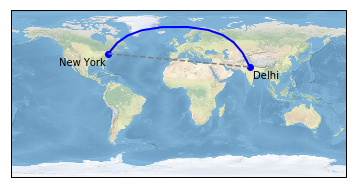

In [1]:

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

ny_lon, ny_lat = -75, 43
delhi_lon, delhi_lat = 77.23, 28.61

plt.plot([ny_lon, delhi_lon], [ny_lat, delhi_lat],
         color='blue', linewidth=2, marker='o',
         transform=ccrs.Geodetic(),
         )

plt.plot([ny_lon, delhi_lon], [ny_lat, delhi_lat],
         color='gray', linestyle='--',
         transform=ccrs.PlateCarree(),
         )

plt.text(ny_lon - 3, ny_lat - 12, 'New York',
         horizontalalignment='right',
         transform=ccrs.Geodetic())

plt.text(delhi_lon + 3, delhi_lat - 12, 'Delhi',
         horizontalalignment='left',
         transform=ccrs.Geodetic())

plt.show()